<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

<a id='content'></a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

По требованию заказчика значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


<a href='#content'>Вернуться к оглавлению</a> 

## Подготовка

<a id='prep'></a>

In [1]:
!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 numpy==1.26.4 matplotlib==3.9.0 -q

In [2]:
!pip install --upgrade scikit-learn==1.2.2 jinja2==3.1.2 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import warnings
import sklearn

from numpy import mean
from numpy import std


from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, TimeSeriesSplit)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
try:
    df = pd.read_csv('../assets/taxi.csv', sep=',', 
                     index_col=[0], parse_dates=[0]) 
except:
    df = pd.read_csv('/datasets/taxi.csv', sep=",", 
                     index_col=[0], parse_dates=[0]) 
df.sort_index(inplace=True)

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
display(pd.DataFrame(df.isna().mean()*100).round(2)
            .style.background_gradient('coolwarm'))

,0
num_orders,0.000000


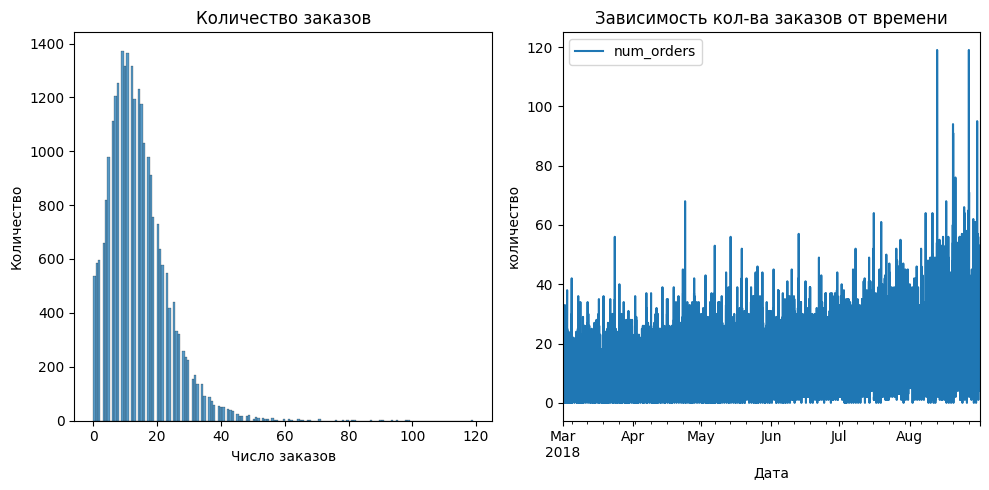

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))  
sns.histplot(df, x='num_orders', ax=axes[0]) 
axes[0].set_title('Количество заказов')
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Число заказов')

df.plot(ax=axes[1]) 
plt.title('Зависимость кол-ва заказов от времени')
axes[1].set_ylabel('количество')
axes[1].set_xlabel('Дата')
plt.tight_layout()
plt.show()


In [8]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [ ]:
print('Диапазон наблюдений с', df.index.min(), 'по', df.index.max())

Диапазон наблюдений с 2018-03-01 00:00:00 по 2018-08-31 23:50:00


**Выводы**

- Данные представлены в виде временного ряда
- Диапазон наблюдений с марта по август 2018г включительно
- Пропуски в данных отсутсвуют
- Увеличенная валатильность в конце временного ряда
- Среднее значение 84 заказа в час, медиана 78, стандартное отклонение 45.
- Название столбца соответсвует стандарту snake_case
- тип данных правильный

<a href='#content'>Вернуться к оглавлению</a> 

## Анализ

<a id="analis"></a>

Выполним ресемплирование. Изменим интервал со значениями ряда и установим его равным 1 часу

In [10]:
df_resample = df.resample('1H').sum()
print('Размер до ресемплинга - ', df.shape, 'после - ', df_resample.shape)

Размер до ресемплинга -  (26496, 1) после -  (4416, 1)


In [11]:
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Добавим скользящее среднее

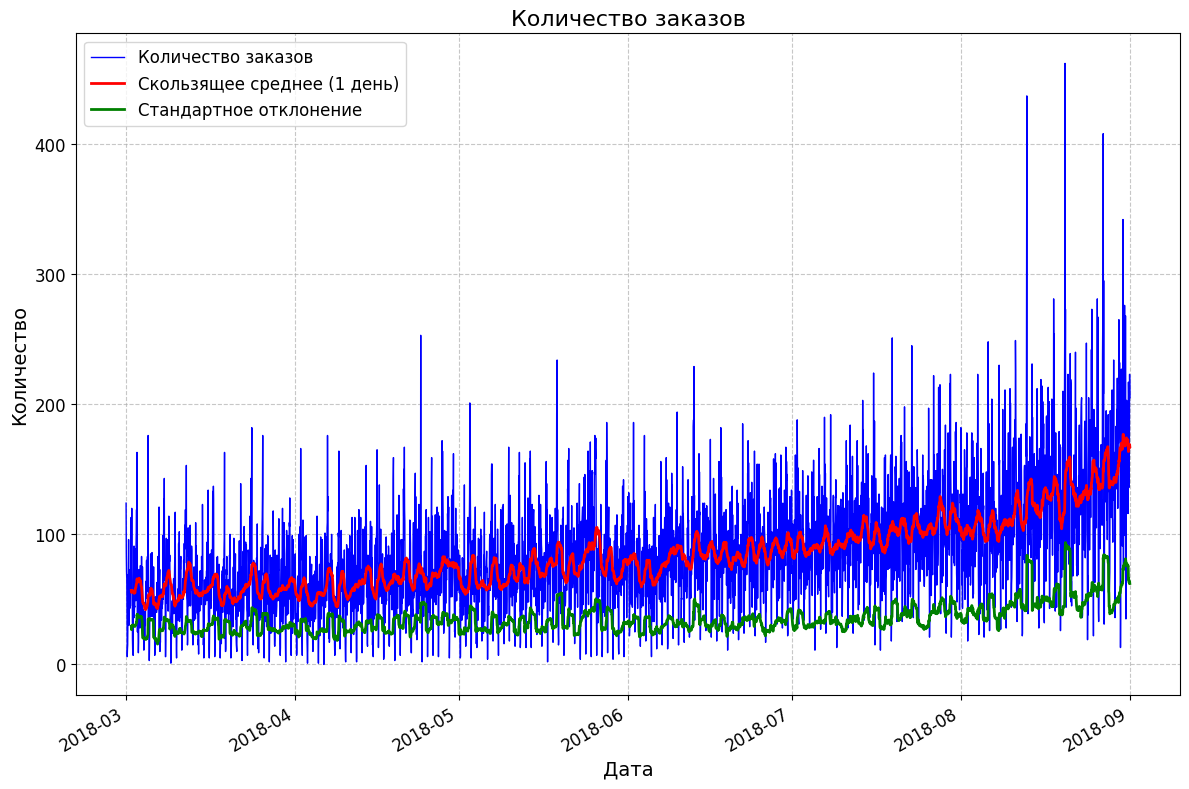

In [12]:
df_stat = df_resample.copy()
df_stat['mean'] = df_stat['num_orders'].rolling(24).mean()
df_stat['std'] = df_stat['num_orders'].rolling(24).std()

fig, ax = plt.subplots(figsize=(12, 8)) 

# Строим исходные данные
ax.plot(df_stat.index, df_stat['num_orders'], 
        label='Количество заказов', 
        color='blue', linewidth=1)

# Строим скользящее среднее
ax.plot(df_stat.index, df_stat['mean'], 
        label='Скользящее среднее (1 день)', 
        color='red', linewidth=2)

# Заполняем область стандартного отклонения
ax.plot(df_stat.index, df_stat['std'], 
        label='Стандартное отклонение', color='green', linewidth=2)

# Настраиваем график
ax.set_title('Количество заказов', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)  # Добавляем сетку

# Улучшаем расположение меток на оси X, если это временные ряды
if isinstance(df_stat.index, pd.DatetimeIndex):
    fig.autofmt_xdate()

plt.tight_layout()
plt.show()

Временной ряд на графике нестационарный, т.к. его среднее значение меняется со временем.
Нестационарные ряды (англ. nonstationary time series) прогнозировать сложнее: их свойства меняются слишком быстро.

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

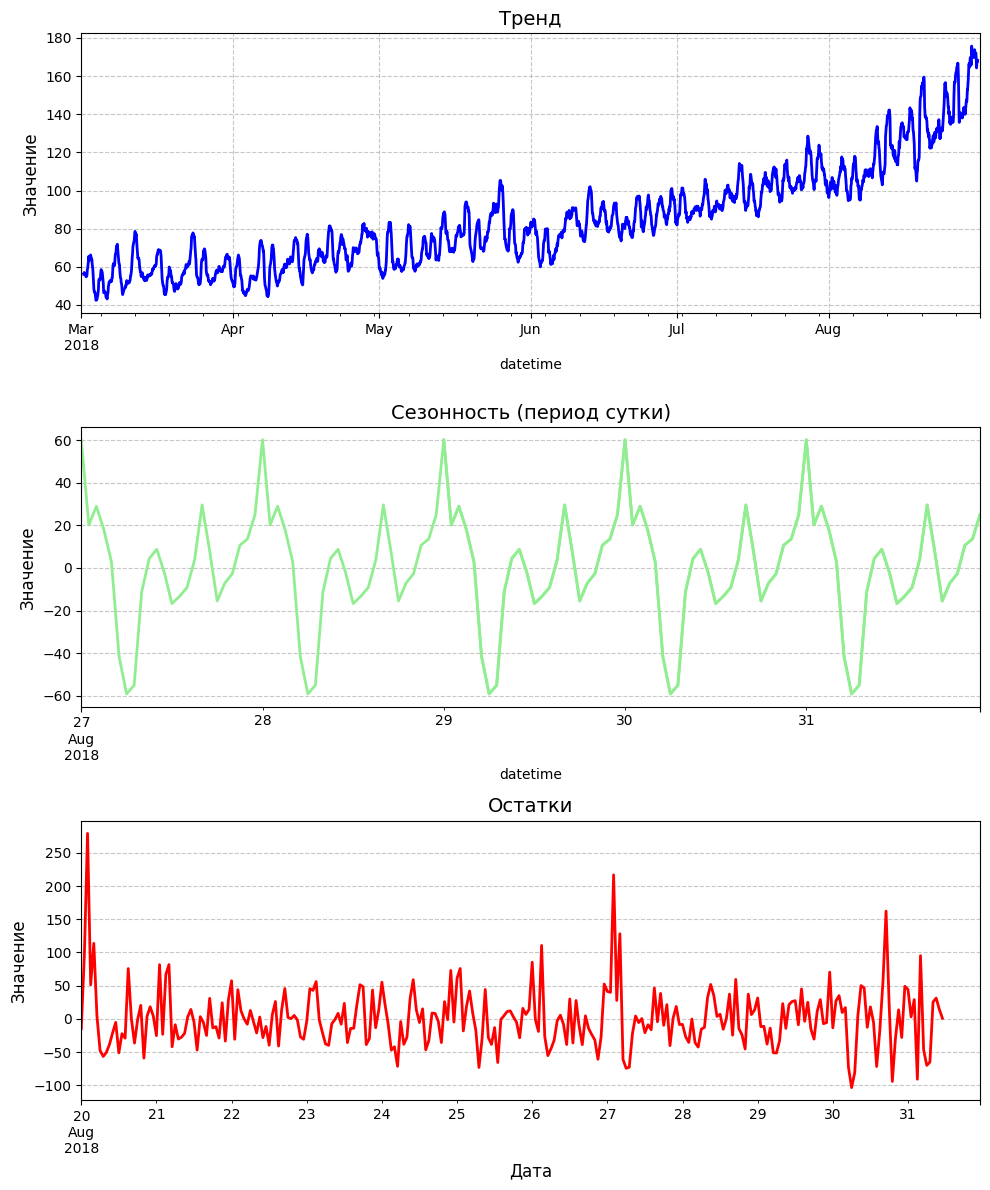

In [13]:
decomposed = seasonal_decompose(df_stat['num_orders'])


plt.figure(figsize=(10, 12))  

# Trend
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), linewidth=2, color='blue') 
plt.title('Тренд', fontsize=14)  
plt.ylabel('Значение', fontsize=12) 
plt.grid(True, linestyle='--', alpha=0.7)  

# Seasonality
plt.subplot(312)
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(ax=plt.gca(), 
                                                    linewidth=2, 
                                                    color='lightgreen')
plt.title('Сезонность (период cутки)', fontsize=14)  
plt.ylabel('Значение', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Seasonality
plt.subplot(312)
decomposed.seasonal['2018-08-27':'2018-08-31'].plot(ax=plt.gca(), 
                                                    linewidth=2, 
                                                    color='lightgreen')
plt.title('Сезонность (период cутки)', fontsize=14) 
plt.ylabel('Значение', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)



# Residuals
plt.subplot(313)
decomposed.resid['2018-08-20':'2018-08-31'].plot(ax=plt.gca(), 
                                                 linewidth=2, 
                                                 color='red')
plt.title('Остатки', fontsize=14)
plt.xlabel('Дата', fontsize=12) 
plt.ylabel('Значение', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Выводы**

- Тренд на увеличение количетсва заказов, 
- Сезонная составляющая показывает стохастический стационарный процесс, его распределение со временем не меняется. Период колебаний - сутки.




Чтобы ряд сделать стационарным, найдём разности его значений.

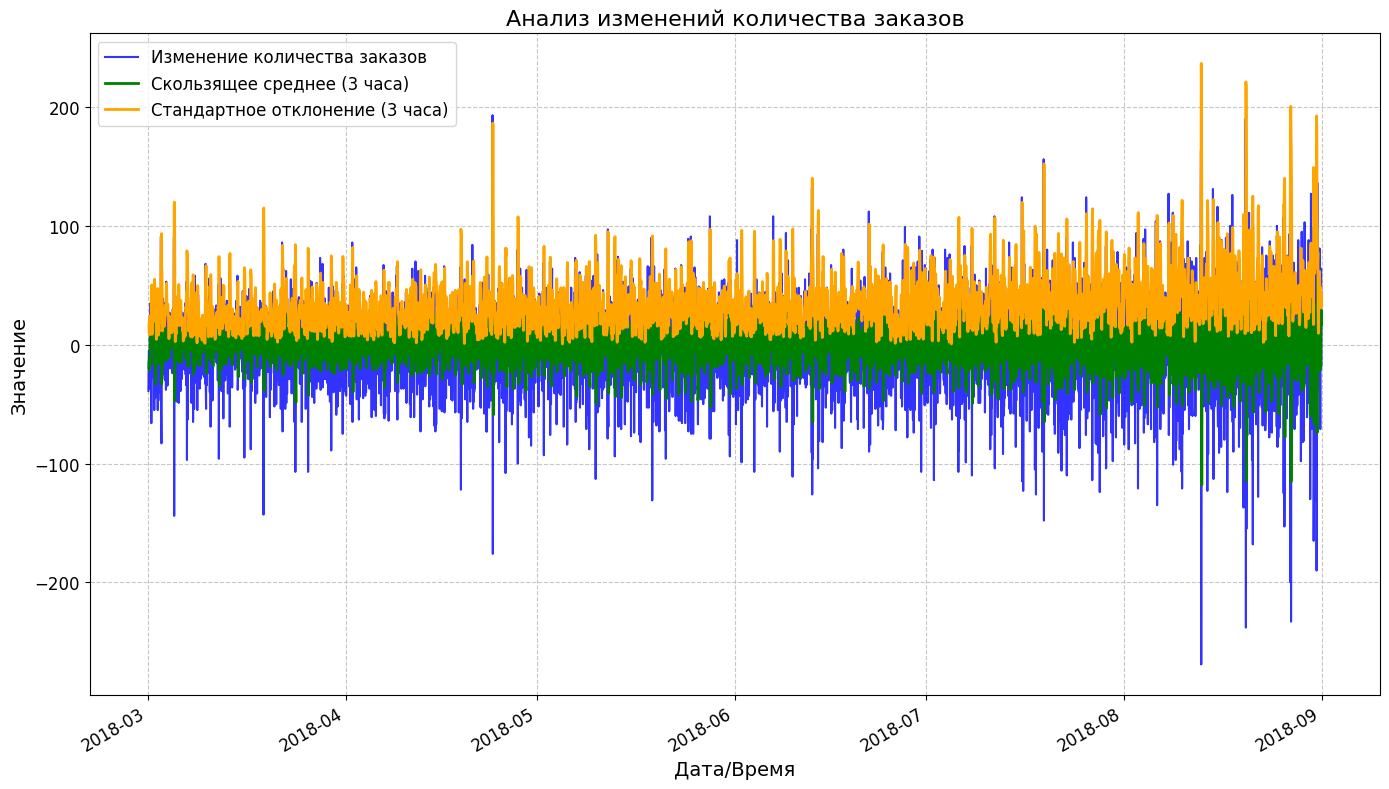

In [14]:
df_shift =df_stat - df_stat.shift()

df_shift['mean'] = df_shift['num_orders'].rolling(3).mean()
df_shift['std'] = df_shift['num_orders'].rolling(3).std()
# Улучшенный график
fig, ax = plt.subplots(figsize=(14, 8))  

# 1. Изменение количества заказов (df_shift['num_orders'])
ax.plot(df_shift.index, df_shift['num_orders'], 
        label='Изменение количества заказов', color='blue', 
        linewidth=1.5, alpha=0.8)

# 2. Скользящее среднее
ax.plot(df_shift.index, df_shift['mean'], 
        label='Скользящее среднее (3 часа)', 
        color='green', linewidth=2)

# 3. Стандартное отклонение
ax.plot(df_shift.index, df_shift['std'], 
        label='Стандартное отклонение (3 часа)', 
        color='orange', linewidth=2)


# Настройка графика
ax.set_title('Анализ изменений количества заказов', fontsize=16)
ax.set_xlabel('Дата/Время', fontsize=14)
ax.set_ylabel('Значение', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12, loc='best') # Размещение легенды
ax.grid(True, linestyle='--', alpha=0.7)

# Автоматическое форматирование оси X для дат, если это необходимо
if isinstance(df_shift.index, pd.DatetimeIndex):
    fig.autofmt_xdate()

plt.tight_layout()
plt.show()

Скользящее среднее не меняется со временем, данное распределение можно отнести к стохастическому стационарному процессу.
Таким образом, разность временного ряда более стационарна, чем сам исходный временной ряд. 



**Вывод**

- В результате разложения на тренд и сезонность замечены колебания с периодом 24 часа
- Основной ряд имеет возрастающий тренд (среднее растет)
- На суточных периодических колебаниях наблюдается 7 экстремумов, т.е. в среднем каждые 3 часа спрос на такси то возрастает, то падает. Именно это значение (3 часа) испольуем в качестве скользящего среднего.
- Чтобы привести ряд к стационарному нашли разность его значений

<a href='#content'>Вернуться к оглавлению</a> 

## Обучение

<a id='educ'></a>

Обучим модель с горизонтом прогнозирования в один час. Чтобы проверять качество моделей возьмём метрику RMSE.
Спрогнозируем временные ряды без обучения двумя способами:
1. Все значения тестовой выборки предсказываются одним и тем же числом (константой). Для метрики RMSE — медиана.
2. Новое значение x(t) прогнозируем предыдущим значением ряда, то есть x(t-1). Этот способ не зависит от метрики.

In [15]:
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [16]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1)
print("Средний объём электропотребления в день:", test['num_orders'].mean())

pred_median = np.ones(test.shape)*train['num_orders'].median()
print("RMSE прогноз константой:", mean_squared_error(test, 
                                                     pred_median, 
                                                     squared=False))

Средний объём электропотребления в день: 139.55656108597285
RMSE прогноз константой: 87.15277582981295


In [17]:
train, test = train_test_split(df_resample, shuffle=False, test_size=0.1)

print("Среднее число заказов:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", mean_squared_error(test, pred_previous, squared=False))

Среднее число заказов: 139.55656108597285
RMSE: 58.856486242815066


Оценка предыдущим значением имеет меньшую ошибку, однако она все еще очень далека от требований заказчика (RMSE ниже 48)

Создадим признаки для горизонта прогнозирования в один шаг.
- Скользящее среднее добавим после разделения на тестовую и тренировочную выборки, чтобы целевой признак не убежал в признаки, на которых будет обучаться модель.Скользящее среднее задаст общий тренд временного ряда.
- Добавим календарные признаки (месяц, день недели, число, час)
- "Отстающие значения" или предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. 

In [18]:
df_resample.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Ранее были замечены суточные периодические колебания. График суточных колебаний имеет 7 экстремумов, т.е. можно сказать, что каждые 3-4 часа спрос на такси то растет, то падает. Именно это значение параметра буем использовать для сглаживания.

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['num_orders'] = (data['num_orders'].shift()
                          .rolling(rolling_mean_size).mean())
    return data


df_new_feature = make_features(df_resample, 1, 3)

df_new_feature.head(10)

,num_orders,month,day,hour,dayofweek,lag_1
datetime,,,,,,
2018-03-01 00:00:00,NaN,3,1,0,3,NaN
2018-03-01 01:00:00,NaN,3,1,1,3,124.0
2018-03-01 02:00:00,NaN,3,1,2,3,85.0
2018-03-01 03:00:00,93.333333,3,1,3,3,71.0
2018-03-01 04:00:00,74.000000,3,1,4,3,66.0
2018-03-01 05:00:00,60.000000,3,1,5,3,43.0
2018-03-01 06:00:00,38.333333,3,1,6,3,6.0
2018-03-01 07:00:00,20.333333,3,1,7,3,12.0
2018-03-01 08:00:00,11.000000,3,1,8,3,15.0


In [20]:
train, test = train_test_split(df_new_feature, shuffle=False, test_size=0.1)


print('Тренировочные данные:', train.index.min(), train.index.max())

print('Тестовые данные:', test.index.min(), test.index.max())

Тренировочные данные: 2018-03-01 00:00:00 2018-08-13 13:00:00
Тестовые данные: 2018-08-13 14:00:00 2018-08-31 23:00:00


In [21]:
test.isna().sum()

num_orders    0
month         0
day           0
hour          0
dayofweek     0
lag_1         0
dtype: int64

In [22]:
train = train.dropna()
train.isna().sum()

num_orders    0
month         0
day           0
hour          0
dayofweek     0
lag_1         0
dtype: int64

In [23]:
train.head()

,num_orders,month,day,hour,dayofweek,lag_1
datetime,,,,,,
2018-03-01 03:00:00,93.333333,3,1,3,3,71.0
2018-03-01 04:00:00,74.000000,3,1,4,3,66.0
2018-03-01 05:00:00,60.000000,3,1,5,3,43.0
2018-03-01 06:00:00,38.333333,3,1,6,3,6.0
2018-03-01 07:00:00,20.333333,3,1,7,3,12.0


In [24]:
X_train = train.drop(columns='lag_1')
y_train = train['lag_1']
X_test = test.drop(columns='lag_1')
y_test = test['lag_1']

model = LinearRegression()
model.fit(X_train,y_train)

# Создаем объект для кросс-валидации с учетом времени
tscv = TimeSeriesSplit(n_splits=5)
y_pred = cross_val_score(model, 
                         X_train, 
                         y_train, 
                         cv=tscv, 
                         scoring='neg_root_mean_squared_error').mean()
print("RMSE модели LinearRegression() на тренировочных данных:", 
      -y_pred)


RMSE модели LinearRegression() на тренировочных данных: 24.022917373246095


 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Отлично, что применяется TimeSeriesSplit, а не простой сплиттер

Ошибка ниже, чем та, что была при предсказании средним или предыдущим значением. Но попробуем улучшить данный результат рассмотрев разные модели с подбором гиперпараметров. А также нормализуя входные признаки

In [25]:
# Создаем пайплайн с масштабированием и моделью
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',LinearRegression())  # Базовая модель (будет заменена)
])

# Сетки гиперпараметров для разных моделей
param_grid = [
    # Для дерева решений
    {
        'model': [DecisionTreeRegressor()],
        'model__max_depth': [3, 5, 7, 10, None],
        'model__min_samples_split': [2, 5, 10],
        'model__criterion': ['squared_error', 'friedman_mse'],
        'scaler': ['passthrough', 'StandardScaler()']
    },
    
    # Для KNN
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': [3, 5, 7, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan'],
        'scaler': ['passthrough', 'StandardScaler()']
    },
    
    # Для SVM
    {
        'model': [SVR()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto', 0.1, 1],
        'scaler': ['passthrough', 'StandardScaler()']
    },
    
    # Для линейной регрессии с регуляризацией
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'model__positive': [True, False],
        'scaler': ['passthrough', 'StandardScaler()']
    }
]
# Создаем объект для кросс-валидации с учетом времени
tscv = TimeSeriesSplit(n_splits=5)

# Инициализация GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
)

# Запуск поиска (X, y - ваши данные)
grid_search.fit(X_train, y_train)

# Вывод результатов
print("Лучшая модель:", grid_search.best_estimator_)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший RMSE:", -grid_search.best_score_)

Лучшая модель: Pipeline(steps=[('scaler', 'passthrough'),
                ('model',
                 DecisionTreeRegressor(max_depth=7, min_samples_split=10))])
Лучшие параметры: {'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_split': 10, 'scaler': 'passthrough'}
Лучший RMSE: 22.284623415267124


In [26]:
# Создаем DataFrame с результатами
result = pd.DataFrame(grid_search.cv_results_)
result = result[
        ['param_model', 'params', 'mean_test_score', 'rank_test_score']
    ]
# Отображаем нужные столбцы с переносом строк
display( result.sort_values(by='rank_test_score').head(5)
    .style
    .set_properties(**{
        'white-space': 'pre-wrap',  # Разрешаем перенос строк
        'text-align': 'left'        # Выравнивание по левому краю
    })
    .hide(axis='index')             # Скрываем индекс
    .format({
        'mean_fit_time': '{:.2f} s', 
        'mean_test_score': '{:.2f}'
    })
)

param_model,params,mean_test_score,rank_test_score
"DecisionTreeRegressor(max_depth=7, min_samples_split=10)","{'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_split': 10, 'scaler': 'passthrough'}",-22.28,1
"DecisionTreeRegressor(max_depth=7, min_samples_split=10)","{'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'friedman_mse', 'model__max_depth': 7, 'model__min_samples_split': 10, 'scaler': 'passthrough'}",-22.29,2
"DecisionTreeRegressor(max_depth=7, min_samples_split=10)","{'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_split': 10, 'scaler': 'passthrough'}",-22.33,3
"DecisionTreeRegressor(max_depth=7, min_samples_split=10)","{'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'friedman_mse', 'model__max_depth': 5, 'model__min_samples_split': 10, 'scaler': 'passthrough'}",-22.33,4
"DecisionTreeRegressor(max_depth=7, min_samples_split=10)","{'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'friedman_mse', 'model__max_depth': 10, 'model__min_samples_split': 10, 'scaler': 'passthrough'}",-22.49,5


In [27]:
best_model = grid_search.best_estimator_

**Выводы**

- Обучено несколько простых моделей (предсказание средним и со сдвигом на предыдущее значение), но данные модели показали слишком большую ошибку
- Синтезированы новые входные признаки, которые учитывают и возрастающий тренд временного ряда и суточные колебания
- Обучены модели: деревьев решений, ближайших соседей, опорных векторов и линейной регрессии. Подобраны гиперпараметры методом gridsearch с использованием кросс-валидации для  временных рядов. 
- Выбрана лучшая:

In [28]:
print("модель с параметрами", grid_search.best_params_)
print("Ошибка RMSE:", -grid_search.best_score_)

модель с параметрами {'model': DecisionTreeRegressor(max_depth=7, min_samples_split=10), 'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_split': 10, 'scaler': 'passthrough'}
Ошибка RMSE: 22.284623415267124


<a href='#content'>Вернуться к оглавлению</a> 

## Тестирование

<a id='test'></a>

Протестируем выбранную модель DecisionTreeRegressor(max_depth=7, 

                                                    min_samples_split=10), 

                                                    'model__criterion': 'squared_error', 

                                                    'model__max_depth': 7,

                                                     'model__min_samples_split': 10, 
                                                     
                                                     'scaler': 'passthrough')

на тестовой выборке

In [29]:
pred_test = best_model.predict(X_test)
print("RMSE на тестовых данных:", mean_squared_error(y_test, 
                                                     pred_test, 
                                                     squared=False).round(0))

RMSE на тестовых данных: 40.0


In [30]:
pred_test= pd.DataFrame(pred_test)
y_test= pd.DataFrame(y_test)

In [31]:
pred_result = y_test.copy()
pred_result.reset_index(inplace=True)
pred_result['lag_1_pred'] = pred_test[0]
pred_result['residuals'] = pred_result['lag_1'] - pred_result['lag_1_pred']
pred_result.set_index('datetime', inplace=True)
pred_result.head()

,lag_1,lag_1_pred,residuals
datetime,,,
2018-08-13 14:00:00,119.0,114.515464,4.484536
2018-08-13 15:00:00,102.0,114.515464,-12.515464
2018-08-13 16:00:00,175.0,152.611111,22.388889
2018-08-13 17:00:00,144.0,136.260870,7.739130
2018-08-13 18:00:00,152.0,136.260870,15.739130


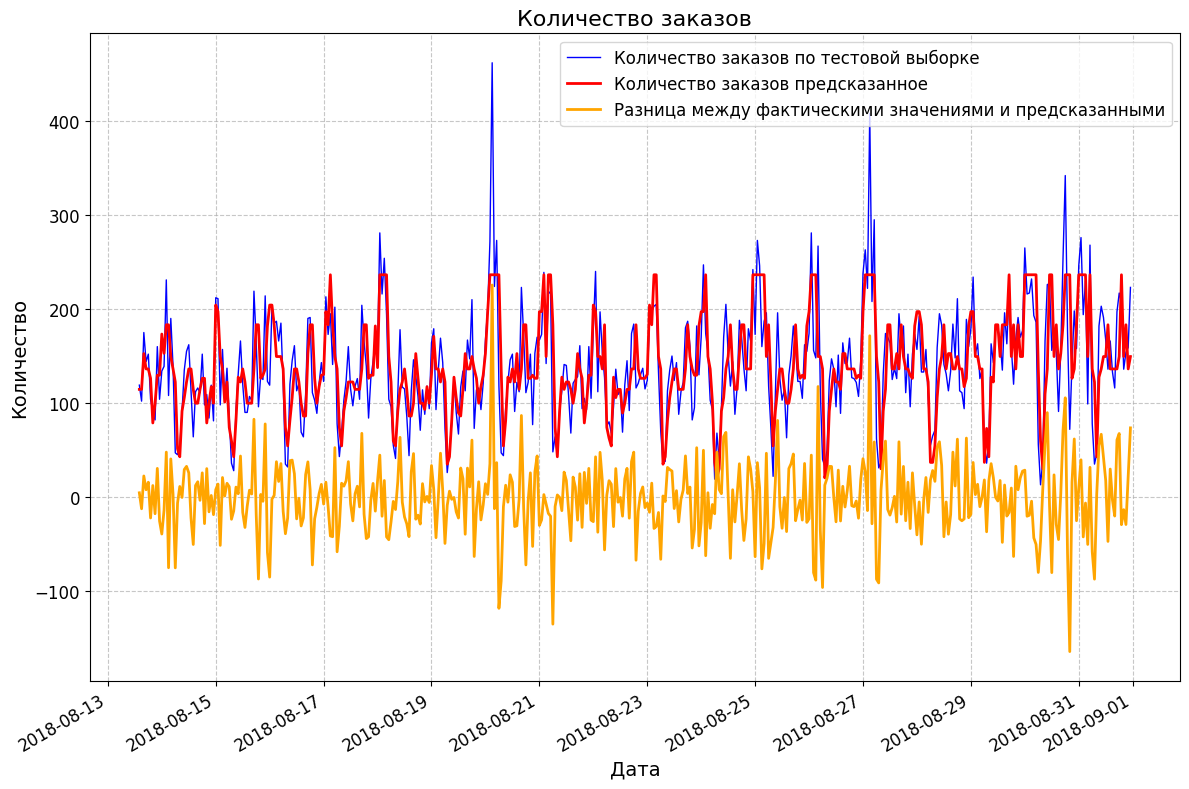

In [32]:
fig, ax = plt.subplots(figsize=(12, 8)) 
# Строим исходные данные
ax.plot(pred_result.index, pred_result['lag_1'], 
        label='Количество заказов по тестовой выборке', 
        color='blue', linewidth=1)
# Строим предсказанные данные
ax.plot(pred_result.index, pred_result['lag_1_pred'], 
        label='Количество заказов предсказанное', 
        color='red', linewidth=2)
#  Остатки
ax.plot(pred_result.index, pred_result['residuals'], 
        label='Разница между фактическими значениями и предсказанными', 
        color='orange', linewidth=2)
# Настраиваем график
ax.set_title('Количество заказов', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)  # Добавляем сетку

# Улучшаем расположение меток на оси X, если это временные ряды
if isinstance(df_stat.index, pd.DatetimeIndex):
    fig.autofmt_xdate()

plt.tight_layout()
plt.show()

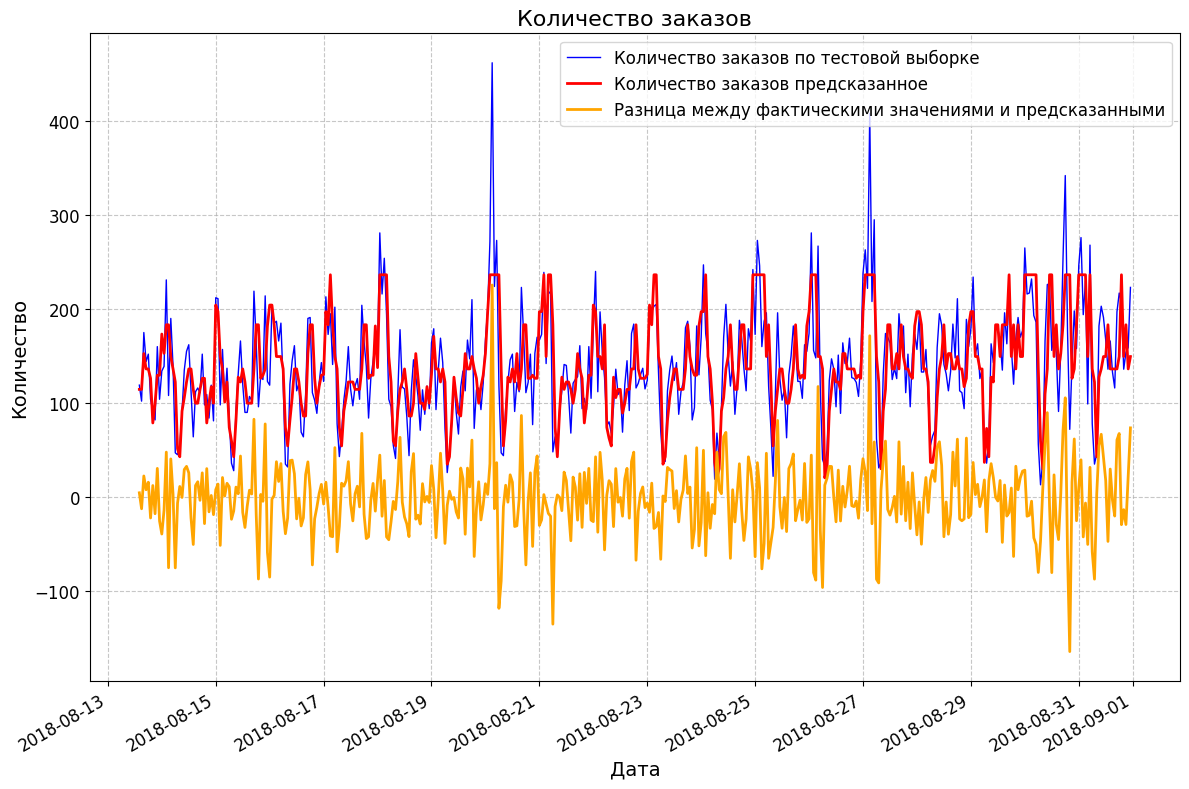

In [33]:
fig, ax = plt.subplots(figsize=(12, 8)) 
# Строим исходные данные
ax.plot(pred_result.index, pred_result['lag_1'], 
        label='Количество заказов по тестовой выборке', 
        color='blue', linewidth=1)
# Строим предсказанные данные
ax.plot(pred_result.index, pred_result['lag_1_pred'], 
        label='Количество заказов предсказанное', 
        color='red', linewidth=2)
#  Остатки
ax.plot(pred_result.index, pred_result['residuals'], 
        label='Разница между фактическими значениями и предсказанными', 
        color='orange', linewidth=2)
# Настраиваем график
ax.set_title('Количество заказов', fontsize=16)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)  # Добавляем сетку

# Улучшаем расположение меток на оси X, если это временные ряды
if isinstance(df_stat.index, pd.DatetimeIndex):
    fig.autofmt_xdate()

plt.tight_layout()
plt.show()

**Выводы**

Ошибка RMSE на тестовой выборке 40, что удовлетворяет требованиям заказчика.

Анализ графика:

*Соответствие:* В целом, предсказанные значения (красный ряд) достаточно хорошо соответствуют фактическим значениям (синий ряд). Это говорит о том, что модель достаточно точно предсказывает количество заказов.

*Колебания:* Оба ряда демонстрируют значительные колебания. Видно несколько пиков, соответствующих дням с повышенным количеством заказов. Модель в целом успешно отслеживает эти колебания.

*Небольшие расхождения:* В некоторых точках наблюдаются небольшие расхождения между фактическими и предсказанными значениями. Это может быть связано с тем, что модель не идеально учитывает все факторы, влияющие на количество заказов.

*Общая тенденция:* Общая тенденция изменения количества заказов, кажется, восходящей или стабильной в течение рассматриваемого периода.

Анализ остатков не показывает каких-то закономерностей, которые могли быть пропущены при обучении модели. 


<a href='#content'>Вернуться к оглавлению</a> 

## Выводы

<a id='end'></a>



Модель, вероятно, хорошо подходит для прогнозирования количества заказов на данном временном ряду.
Ошибка RMSE - 40, показывает, что в среднем модель ошибается на 40 заказов. 
Наблюдаемые небольшие расхождения между фактическими и предсказанными значениями могут быть связаны с неидеальностью модели или с наличием факторов, которые модель не учитывает.
Для дальнейшего улучшения точности прогнозов можно попробовать:
Использовать более сложные модели прогнозирования временных рядов, такие как ARIMA или Prophet.
Добавить в модель дополнительные признаки, которые могут влиять на количество заказов (например, праздники, акции), на графике видно, что хуже всего модель улавливает отдельные пиковые значения, которые могут быть связаны с ухудшением прогноза погода или празничными днями.

<a href='#content'>Вернуться к оглавлению</a> 